<a href="https://colab.research.google.com/github/eminekilics/embedded_system_network_security_dataset/blob/main/embedded_system_network_security_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold

In [ ]:
df = pd.read_csv("embedded_system_network_security_dataset.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (1000, 18)
   packet_size  inter_arrival_time  src_port  dst_port  packet_count_5s  \
0     0.405154            0.620362     62569       443         0.857143   
1     0.527559            0.741288     59382       443         0.785714   
2     0.226199            0.485116     65484        80         0.285714   
3     0.573372            0.450965     51707        53         0.142857   
4     0.651396            0.888740     26915        53         0.714286   

   mean_packet_size  spectral_entropy  frequency_band_energy  label  \
0               0.0          0.834066               0.534891    0.0   
1               0.0          0.147196               0.990757    0.0   
2               0.0          0.855192               0.031781    0.0   
3               0.0          0.153220               0.169958    0.0   
4               0.0          0.923916               0.552053    0.0   

   protocol_type_TCP  protocol_type_UDP  src_ip_192.168.1.2  \
0              False             

In [ ]:
# Remove duplicate lines
df.drop_duplicates(inplace=True)

# Identify the target column
# In the dataset, it is usually ‘label’ or 'anomaly'
target_col = "label" if "label" in df.columns else df.columns[-1]

print("Target column:", target_col)


# Label mapping (0 = Normal, 1 = Anomaly)
df[target_col] = df[target_col].apply(lambda x: 1 if x != 0 else 0)

Target column: label


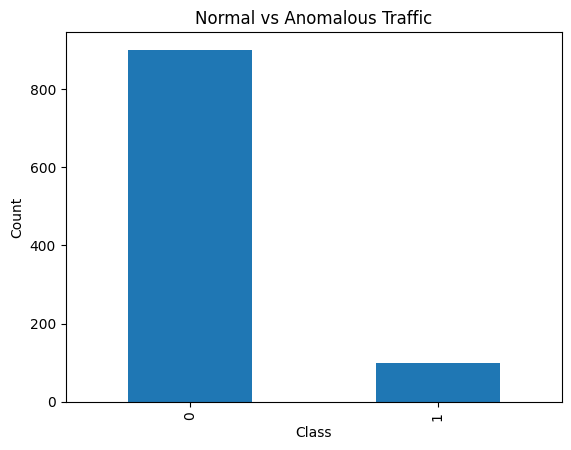

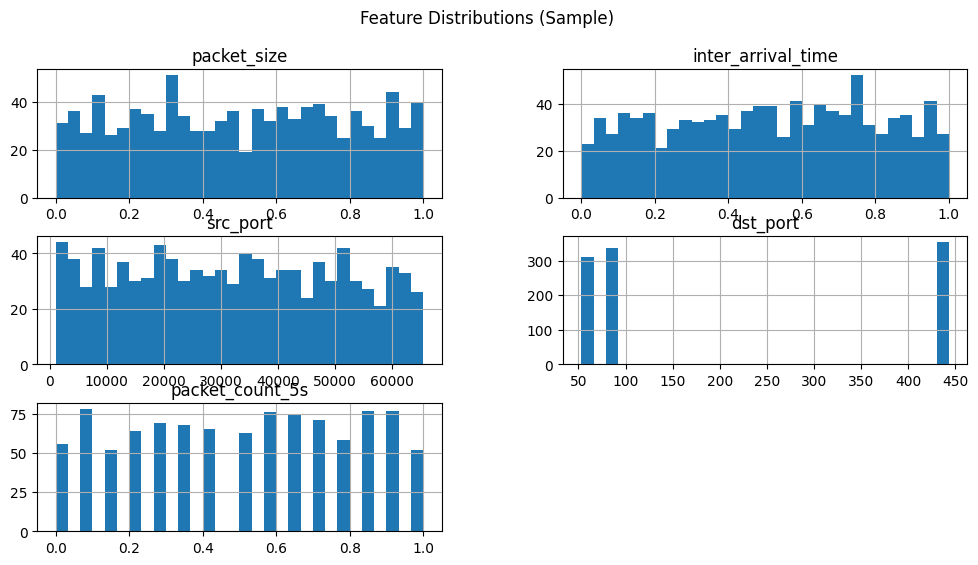

In [ ]:
# Anomaly distribution
df[target_col].value_counts().plot(kind="bar")
plt.title("Normal vs Anomalous Traffic")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Only numerical features
numeric_features = df.select_dtypes(include=[np.number]).drop(columns=[target_col])

# Feature distributions (top 5 features)
numeric_features.iloc[:, :5].hist(bins=30, figsize=(12, 6))
plt.suptitle("Feature Distributions (Sample)")
plt.show()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

In [ ]:
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(numeric_features)

selected_features = numeric_features.columns[selector.get_support()]
numeric_features = numeric_features[selected_features]

X_scaled = scaler.fit_transform(numeric_features)

In [ ]:
df[target_col].value_counts(normalize=True)

,proportion
label,
0,0.9
1,0.1


In [ ]:
contamination=df[target_col].mean()

In [ ]:
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.1,
    random_state=42
)

df["anomaly_pred"] = iso_forest.fit_predict(X_scaled)

# Isolation Forest:
# -1 = anomaly, 1 = normal
df["anomaly_pred"] = df["anomaly_pred"].map({1: 0, -1: 1})

In [ ]:
print("\nClassification Report:\n")
print(classification_report(df[target_col], df["anomaly_pred"]))

print("Confusion Matrix:")
print(confusion_matrix(df[target_col], df["anomaly_pred"]))


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       900
           1       0.15      0.15      0.15       100

    accuracy                           0.83      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.83      0.83      0.83      1000

Confusion Matrix:
[[815  85]
 [ 85  15]]



Top Features with Highest Mean Difference:
src_port                 3597.158889
dst_port                  125.190000
packet_count_5s             0.074921
spectral_entropy            0.059951
frequency_band_energy       0.014676
packet_size                 0.009868
inter_arrival_time          0.004518
mean_packet_size            0.000000
dtype: float64


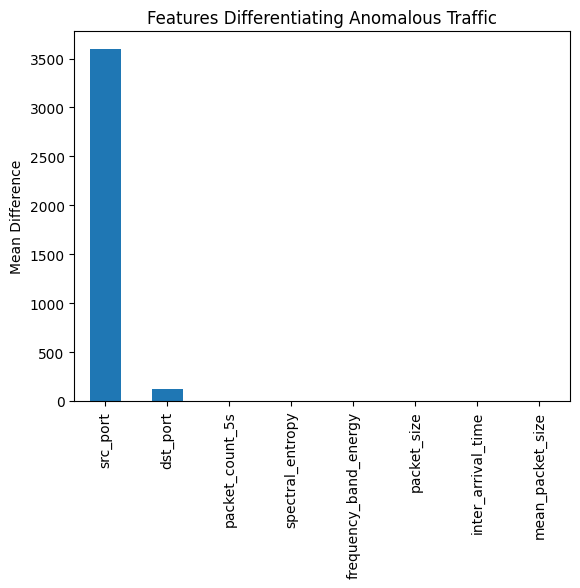

In [ ]:
normal_traffic = df[df["anomaly_pred"] == 0]
anomalous_traffic = df[df["anomaly_pred"] == 1]

mean_diff = (
    anomalous_traffic[numeric_features.columns].mean()
    - normal_traffic[numeric_features.columns].mean()
).abs().sort_values(ascending=False)

print("\nTop Features with Highest Mean Difference:")
print(mean_diff.head(10))

mean_diff.head(10).plot(kind="bar")
plt.title("Features Differentiating Anomalous Traffic")
plt.ylabel("Mean Difference")
plt.show()

In [ ]:
# Decision function: how anomalous
df["risk_score"] = iso_forest.decision_function(X_scaled)

# Normalize to 0–100
df["risk_score"] = (df["risk_score"].max() - df["risk_score"]) / \
                   (df["risk_score"].max() - df["risk_score"].min()) * 100

# Risk levels
def risk_level(score):
    if score > 80:
        return "HIGH"
    elif score > 50:
        return "MEDIUM"
    else:
        return "LOW"

df["risk_level"] = df["risk_score"].apply(risk_level)

In [ ]:
alerts = df[df["risk_level"] == "HIGH"]

alerts.to_csv("high_risk_network_traffic.csv", index=False)

print("\nHigh-risk traffic samples saved.")
print(alerts.head())


High-risk traffic samples saved.
     packet_size  inter_arrival_time  src_port  dst_port  packet_count_5s  \
210     0.808876            0.969643     61625       443         0.928571   
864     0.881174            0.015099      2381       443         0.857143   
933     0.172513            0.423670     64871       443         1.000000   

     mean_packet_size  spectral_entropy  frequency_band_energy  label  \
210               0.0          0.047829               0.787012      0   
864               0.0          0.948634               0.959133      0   
933               0.0          0.012472               0.986927      0   

     protocol_type_TCP  ...  src_ip_192.168.1.2  src_ip_192.168.1.3  \
210              False  ...               False               False   
864              False  ...               False                True   
933              False  ...                True               False   

     dst_ip_192.168.1.5  dst_ip_192.168.1.6  tcp_flags_FIN  tcp_flags_SYN  \
21

In [ ]:
print("\nAnalysis completed successfully.")


Analysis completed successfully.
